<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/emo_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !pip install keras-tuner
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [44]:
from sentiment.utils import read_data
import pandas as pd

In [39]:
cols = ['text', 'emotions']

In [40]:
data = read_data('/content/drive/MyDrive/emotion/data/text_emo_tweet.csv', cols)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      50000 non-null  object
 1   emotions  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [42]:
data[['text']].describe().transpose()

,count,unique,top,freq
text,50000,49672,i expected hoped but being at unca has certain...,2


In [47]:
data.groupby('emotions').count().reset_index()

,emotions,text
0,anger,6923
1,fear,5635
2,joy,16982
3,love,4163
4,sadness,14553
5,surprise,1744


In [48]:
target_dist = data.groupby('emotions').count().reset_index()
target_dist['proportion'] = target_dist['text'] / sum(list(target_dist['text']))
target_dist

,emotions,text,proportion
0,anger,6923,0.13846
1,fear,5635,0.11270
2,joy,16982,0.33964
3,love,4163,0.08326
4,sadness,14553,0.29106
5,surprise,1744,0.03488


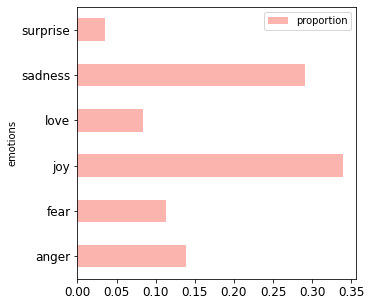

In [54]:
target_dist.plot(x='emotions', y='proportion', kind='barh', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(5,5))